In [455]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import dill
from tqdm import tqdm 
from scipy.signal import find_peaks
import sys
import pyarrow as pa
import io

'''

'''

'\n\n'

In [456]:
sys.path.insert(0,'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import filter_functions as ff
from matplotlib.pyplot import cm

In [457]:
# Fields pull and pull list
os.chdir('D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_Exp2')
PATH = os.getcwd()

analysis_pull_list = []
with open("Analysis_Pull_List.txt", "r") as file:
    analysis_pull_list = file.read().splitlines()
analysis_pull_list_reaction = [s+'_Reaction' for s in analysis_pull_list]
analysis_pull_list_timing = [s+'_Timing' for s in analysis_pull_list]
analysis_pull_list_task = [s+'_Task' for s in analysis_pull_list]

with open("Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
    
num_subjects = len(analysis_pull_list)
task_name = 'Matchpennies_Agent_Exp2'

Target information


- Row 0 = Start Target

- Row 1 = Left screen, right target x pos (left target is 2\*startx - right targetx)

- Dim 1 = Radius

- Dim 2 = Thickness of the circle edge (don't know if this matters)

Dataframe is in centimeters, so need to divide everything by 100


In [458]:
file = 'Sub1_Reaction\\Sub1_ReactionTarget_Table.csv'
df = pd.read_csv(file)
df["X"] = df["X"]/100
df["Y"] = df["Y"]/100
df['Dim 1'] = df['Dim 1']/100 # Target table is in centimeters, I guess this doesn't matter but it makes me feel better
df['Dim 2'] = df['Dim 2']/100
# Target information for Right Hand (keeping this because the positions of target 3 and 4 are based on target 1 and start 1)
startx = df.loc[0]['X']
starty = df.loc[0]['Y']
start_radius = df.loc[0]['Dim 1'] 
adjusted_start_radius = start_radius*1.0 # ! This determines what size target I use to determine target leave time 

target1x = df.loc[1]['X']
target1y = df.loc[1]['Y']
target1_radius = df.loc[1]['Dim 1']

target2x = 2*startx - target1x
target2y = target1y
target2_radius = target1_radius

# Timing target
timing_targetx = startx
timing_targety = target1y
timing_target_pos = np.sqrt(timing_targetx**2 + timing_targety**2)
timing_target_radius = target1_radius   

# Parse Reaction Task Data


In [459]:
def get_force_reaction_time_single_trial(data):
    max_force = np.nanmax(data)
    index_max_force = np.nanargmax(data)
    max25 = 0.25*max_force
    max75 = 0.75*max_force
    max25_timepoint,_ = min(enumerate(data[:index_max_force]), key=lambda x: abs(x[1]-max25)) # Enumerate force to get timepoint and value, only slice up to the max value, then find where it's closest to 25percent of max value
    max75_timepoint,_ = min(enumerate(data[:index_max_force]), key=lambda x: abs(x[1]-max75))
    x1vals = max25_timepoint
    x2vals = max75_timepoint
    y1vals = max25
    y2vals = max75
    if x1vals - x2vals == 0:
        return np.nan
    slopes = (y2vals - y1vals)/(x2vals - x1vals)
    intercepts = y2vals - slopes*x2vals
    time_at_zero = -intercepts/slopes
    player_reaction_time_force = time_at_zero
    return player_reaction_time_force

In [460]:
#%% Get reaction time data
block_table = pd.read_csv(f'Sub1_Reaction\\Sub1_ReactionBlock_Table.csv')
num_trials = block_table['List_Reps'].loc[0]
num_blocks = sum(~block_table['TP_LIST'].isna())
trial_time = 8000
tot_trials = int(sum(block_table['List_Reps']))

filenames = np.empty((num_subjects, num_blocks,num_trials),dtype = object)
trial_start = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan

player_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_yforce_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_yforce_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_velocity_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_yforce_reaction_movement_time = np.zeros_like(player_yforce_reaction_time)
player_reaction_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_plus_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_reach_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_decision_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

trial_type_array = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

reaction_xypos_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time,2))*np.nan
reaction_dist_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
reaction_xyvelocity_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time,2))*np.nan
reaction_speed_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
reaction_xyforce_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time,2))*np.nan
reaction_force_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan


###-------------------------------------------------------------------------------------------------------
for i in range(1):
    subname = analysis_pull_list_reaction[i]
    print(i, subname)
    trial_table = pd.read_csv(subname+f'\\{subname}Trial_Table.csv')
    for x in range(tot_trials):
        block_trial_num = trial_table.iloc[x]['Block_Step']
        block_number = trial_table.iloc[x]['Block_Row']
        tp_num = trial_table.iloc[x]['TP_Row']
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        
        filename = f"{subname}\\{task_name}_{subname}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        filenames[i,j,k] = filename # Store the file name
        data = pd.read_csv(filename,engine='c',dtype={'Event_Codes': 'object'})  # Read in data
        #* Find the trial start time with event codes
        event_code_col = data['Event_Codes']
        if 'E_GO_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_GO_TRIAL'].index[-1]) #! Indexed at -1 bc if they need to redo the trial, we should use the last E_GO_TRIAL, not the first 
            trial_type_array[i,j,k] = 1 
        elif 'E_SHUTOFF_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_SHUTOFF_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 0
        else:
            raise Exception('ERROR, event code not found')
            
        #* Get Reaction Time Data
        end_time = start_time + trial_time      # Find how long the trial is, constant in this case to give people time to make it
        trial_start[i,j,k] = start_time         # Store the start times, NOT THE AGENT DECISION TIMES
        agent_reaction_decision_time[i,j,k] = data.iloc[start_time]['Agent_Decision_Time'] # Store the agent go time
        cutoff_data = data.iloc[start_time:end_time] # Constrain data to the time that the trial starts, to the time that it ends
            
        reaction_xypos_data[i,j,k,:len(cutoff_data),:] = np.array(cutoff_data.drop(['Event_Codes'],axis=1)[['Left_HandX','Left_HandY']]) # Store left and right, slicing 3rd axis so if the trial ends early, then we just have nans at the end
        lhx = cutoff_data['Left_HandX'].to_numpy() # Left hand x position
        lhy = cutoff_data['Left_HandY'].to_numpy() # Left hand y position 
        lhx_vel = cutoff_data['Left_HandXVel'].to_numpy() # Left hand x velocity
        lhy_vel = cutoff_data['Left_HandYVel'].to_numpy() # Left hand y velocity
        lhx_force = cutoff_data['Left_FS_ForceX'].to_numpy()
        lhy_force = cutoff_data['Left_FS_ForceY'].to_numpy()
        
        # Filter force
        fx_nan_mask = ~np.isnan(lhx_force)
        fy_nan_mask = ~np.isnan(lhy_force)
        lhx_force_filt = np.zeros(trial_time)*np.nan
        lhy_force_filt = np.zeros(trial_time)*np.nan
        lhx_force_filt[:np.count_nonzero(fx_nan_mask)] = ff.Filter_KIN(lhx_force[fx_nan_mask])
        lhy_force_filt[:np.count_nonzero(fy_nan_mask)] = ff.Filter_KIN(lhy_force[fy_nan_mask])
        # Filter velocity
        vx_nan_mask = ~np.isnan(lhx_vel)
        vy_nan_mask = ~np.isnan(lhy_vel)
        lhx_vel_filt = np.zeros(trial_time)*np.nan
        lhy_vel_filt = np.zeros(trial_time)*np.nan
        lhx_vel_filt[:np.count_nonzero(fx_nan_mask)] = ff.Filter_KIN(lhx_vel[fx_nan_mask])
        lhy_vel_filt[:np.count_nonzero(fy_nan_mask)] = ff.Filter_KIN(lhy_vel[fy_nan_mask])
        #* Get force, speed, dist and store them in arrays
        reaction_xypos_data[i,j,k,:len(lhx),0] = lhx
        reaction_xypos_data[i,j,k,:len(lhx),1] = lhy
        dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2) # Calculate dist
        reaction_dist_data[i,j,k,:len(dist)] = dist # Store dist

        reaction_xyforce_data[i,j,k,:len(lhx_force_filt),0] = lhx_force_filt
        reaction_xyforce_data[i,j,k,:len(lhx_force_filt),1] = lhy_force_filt
        force = np.sqrt(lhx_force_filt**2 + lhy_force_filt**2)
        reaction_force_data[i,j,k,:] = force

        reaction_xyvelocity_data[i,j,k,:len(lhx_vel_filt),0] = lhx_vel_filt
        reaction_xyvelocity_data[i,j,k,:len(lhx_vel_filt),1] = lhy_vel_filt
        speed = np.sqrt((lhx_vel_filt)**2 + (lhy_vel_filt)**2) # Calculate velocity
        reaction_speed_data[i,j,k,:len(speed)] = speed # Store velocity 

        player_yforce_reaction_decision_time[i,j,k] = get_force_reaction_time_single_trial(lhy_force_filt) 
        player_yforce_reaction_time[i,j,k] = player_yforce_reaction_decision_time[i,j,k] - agent_reaction_decision_time[i,j,k]
        player_velocity_reaction_time[i,j,k] = get_force_reaction_time_single_trial(speed) - agent_reaction_decision_time[i,j,k]

        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius) # Find when people enter the right target
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) # Find when people enter the left target
        s = np.argwhere(dist > adjusted_start_radius)  # Find when people leave the start
        t = np.argwhere(np.sqrt((lhx_vel)**2 + (lhy_vel)**2) > 0.05) # Find when people's velocity is greater than 0.05 cm/s
        
        if np.size(t)>0:
            player_reaction_time_vel[i,j,k] = t[0] - agent_reaction_decision_time[i,j,k]
            player_reaction_decision_time_vel[i,j,k] = t[0]
        else:
            raise Exception('no velocity threshold crossed')
        if np.size(s)>0: 
            player_reaction_decision_time[i,j,k] = s[0]
            player_reaction_time[i,j,k] = s[0]  - agent_reaction_decision_time[i,j,k]
            
            #TODO Check lower threshold of speed up to the time that they leave the target to get the true decision time 
            
        else:
            raise Exception('no position threshold crossed')
        if np.size(q)>0: #if LH enters right target
            player_reaction_decision_array[i,j,k] = 1
            player_reaction_movement_time[i,j,k] = q[0] - s[0]
            player_yforce_reaction_movement_time[i,j,k] = q[0] - player_yforce_reaction_decision_time[i,j,k]
            player_reaction_plus_movement_time[i,j,k] = q[0] - agent_reaction_decision_time[i,j,k]
            
        elif np.size(r)>0: #if LH enters left target
            player_reaction_decision_array[i,j,k] = -1   
            player_reaction_movement_time[i,j,k] = r[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = r[0] - agent_reaction_decision_time[i,j,k]          
            player_yforce_reaction_movement_time[i,j,k] = r[0] - player_yforce_reaction_decision_time[i,j,k]

        # #plot path for Reactions
        if False:
            # for i in range(1):
            # plot_end_time = int(agent_reaction_decision_time[i,j,k] + player_reaction_time[i,j,k])
            # plot_end_time = int(start_time + 500)
            lhx_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandX'])
            lhy_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandY'])
            # plt.figure(dpi=300)
            # circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
            # circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
            # startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
            # fig, ax = plt.subplots()
            # ax.add_patch(circleR)
            # ax.add_patch(circleL)
            # ax.add_patch(startCirc)
            # plt.plot(lhx,lhy) 
            # plt.show()
            # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
            # print(player_reaction_time[i,j,k])
            # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
            fig,ax = plt.subplots()
            dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2)
            plt.plot(dist)
            plt.scatter(s[0],dist[int(s[0])])
            plt.plot(speed)
            
            plt.scatter(t[0],speed[int(t[0])])
            plt.show()

 
 

0 Sub9_Reaction


In [461]:
def get_linear_reaction_time(data):
    nan_mask = np.isnan(data)
    data[nan_mask] = 0
    max_force = np.nanmax(data,axis=3)
    index_max_force = np.nanargmax(data,axis=3)

    max25 = 0.25*max_force
    max75 = 0.75*max_force
    max25_array = np.repeat(max25[...,np.newaxis],8000,axis=3)
    max75_array = np.repeat(max75[...,np.newaxis],8000,axis=3)

    indices = np.arange(0,8000,1)
    indices_tiled = np.tile(indices,(2,3,100,1))
    index_max_force_array = np.repeat(index_max_force[...,np.newaxis],8000,axis=3)
    max_force_mask = indices_tiled < index_max_force_array
    max25_timepoints = np.argmin(abs(data*max_force_mask - max25_array),axis=3).astype('float')
    max75_timepoints = np.argmin(abs(data*max_force_mask - max75_array),axis=3).astype('float')

    max25[max25==0] = np.nan
    max75[max75==0] = np.nan
    max25_timepoints[max25_timepoints==0] = np.nan
    max75_timepoints[max75_timepoints==0] = np.nan

    x1vals = max25_timepoints
    x2vals = max75_timepoints
    y1vals = max25
    y2vals = max75
    # if x1vals - x2vals == 0:
    #     return np.nan
    slopes = (y2vals - y1vals)/(x2vals - x1vals)
    intercepts = y2vals - slopes*x2vals
    time_at_zero = -intercepts/slopes
    return time_at_zero

In [462]:
player_reaction_decision_times_vec = np.argmax(reaction_dist_data > adjusted_start_radius,axis=3)
player_reaction_times_vec = player_reaction_decision_times_vec - agent_reaction_decision_time
player_velocity_decision_time_thresh_vec = np.argmax(reaction_speed_data > 0.05,axis=3)
player_velocity_reaction_times_tresh_vec = player_velocity_decision_time_thresh_vec - agent_reaction_decision_time
player_velocity_reaction_decision_time_linear_vec = get_linear_reaction_time(reaction_speed_data)
player_velocity_reaction_time_linear_vec = player_velocity_reaction_decision_time_linear_vec - agent_reaction_decision_time


array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
    

In [477]:
s = player_reaction_plus_movement_time + agent_reaction_decision_time

In [478]:
q = np.argmax(np.sqrt((reaction_xypos_data[...,0]-target1x)**2 + (reaction_xypos_data[...,1]    -target1y)**2) < target1_radius,axis=3)
r = np.argmax(np.sqrt((reaction_xypos_data[...,0]-target2x)**2 + (reaction_xypos_data[...,1]    -target2y)**2) < target2_radius,axis=3)
np.maximum(q,r) == s

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  Tr

In [464]:
player_velocity_decision_time_vec 

array([[[1513, 1137, 1203, 1538, 1256,  983, 1318, 1511, 1277, 1039,
         1295, 1803, 1112, 1426, 1189, 1091, 1438, 1334, 1007, 1170,
         1173, 1073, 1535, 1179, 1308, 1205, 1280, 1203, 1089, 1164,
         1030, 1151, 1124, 2050, 1461, 1101, 1666, 1081, 1490, 1021,
         1052, 1090, 1046,  967, 1157, 1147, 1472, 1319, 1193, 1227,
         1520, 1523, 1251, 1199, 1215, 1218, 1204, 1294, 1040, 1719,
         1240, 1078, 1040, 1107, 1215, 1174, 1137, 1997, 1178, 1647,
         1574, 1189, 1054, 1181, 1241, 1126, 1124, 1150, 1160, 1629,
         1208, 1246, 1183, 1121, 1397, 1091, 1238, 1864, 1541, 1260,
         1108, 1222, 1090, 1111, 1079, 1094, 1149, 1704, 1057, 5005],
        [1136, 1128, 1154, 1214, 1127, 1245, 1419, 1100, 1190, 1159,
         1193, 1350, 1059, 1146, 1196, 1066, 1103, 1180, 1194, 1124,
         1248, 1219, 1157, 1191, 1157, 1269, 1328, 1459, 1290, 1093,
         1271, 1280, 1265, 1201, 1275, 1149, 1186, 1297, 1411, 1179,
         1225, 1183, 1269, 1170, 

In [465]:
player_velocity_decision_time_vec[0,0,:]

array([1513, 1137, 1203, 1538, 1256,  983, 1318, 1511, 1277, 1039, 1295,
       1803, 1112, 1426, 1189, 1091, 1438, 1334, 1007, 1170, 1173, 1073,
       1535, 1179, 1308, 1205, 1280, 1203, 1089, 1164, 1030, 1151, 1124,
       2050, 1461, 1101, 1666, 1081, 1490, 1021, 1052, 1090, 1046,  967,
       1157, 1147, 1472, 1319, 1193, 1227, 1520, 1523, 1251, 1199, 1215,
       1218, 1204, 1294, 1040, 1719, 1240, 1078, 1040, 1107, 1215, 1174,
       1137, 1997, 1178, 1647, 1574, 1189, 1054, 1181, 1241, 1126, 1124,
       1150, 1160, 1629, 1208, 1246, 1183, 1121, 1397, 1091, 1238, 1864,
       1541, 1260, 1108, 1222, 1090, 1111, 1079, 1094, 1149, 1704, 1057,
       5005], dtype=int64)

In [466]:
player_reaction_decision_times_vec[0,0,:]

array([1566, 1176, 1242, 1598, 1315, 1028, 1369, 1562, 1318, 1091, 1370,
       1855, 1152, 1488, 1246, 1151, 1484, 1393, 1058, 1222, 1199, 1119,
       1588, 1225, 1365, 1253, 1327, 1242, 1146, 1211, 1085, 1207, 1173,
       2103, 1563, 1151, 1708, 1100, 1541, 1061, 1093, 1121, 1089,  999,
       1213, 1200, 1516, 1373, 1216, 1270, 1379, 1572, 1294, 1230, 1286,
       1276, 1339, 1341, 1076, 1774, 1296, 1126, 1092, 1173, 1259, 1211,
       1198, 2037, 1218, 1703, 1636, 1242, 1116, 1252, 1293, 1201, 1182,
       1202, 1229, 1726, 1271, 1312, 1230, 1169, 1447, 1145, 1295, 1927,
       1600, 1320, 1165, 1272, 1136, 1178, 1131, 1148, 1209, 1769, 1114,
       5065], dtype=int64)

In [467]:
player_reaction_decision_times_vec[0,0,:] - player_velocity_decision_time_vec[0,0,:]

array([  53,   39,   39,   60,   59,   45,   51,   51,   41,   52,   75,
         52,   40,   62,   57,   60,   46,   59,   51,   52,   26,   46,
         53,   46,   57,   48,   47,   39,   57,   47,   55,   56,   49,
         53,  102,   50,   42,   19,   51,   40,   41,   31,   43,   32,
         56,   53,   44,   54,   23,   43, -141,   49,   43,   31,   71,
         58,  135,   47,   36,   55,   56,   48,   52,   66,   44,   37,
         61,   40,   40,   56,   62,   53,   62,   71,   52,   75,   58,
         52,   69,   97,   63,   66,   47,   48,   50,   54,   57,   63,
         59,   60,   57,   50,   46,   67,   52,   54,   60,   65,   57,
         60], dtype=int64)

In [468]:
a = player_reaction_decision_time_velocity_vec - agent_reaction_decision_time

In [469]:
player_reaction_decision_times_vec[0,0,:] - player_reaction_decision_time_velocity_vec[0,0,:] 

array([ 143.5,  651.5,   77. ,   91. ,  137. ,   82.5,   62.5,   67. ,
         61. ,   71.5,  193. ,   66. ,   70.5,   87.5,   73. ,   82.5,
         61. ,   79. ,   72. ,   74. ,  -13.5,   56.5,   69. ,   55. ,
         71.5,   62. ,   66. ,   55. ,   75. ,   69. ,   75. ,   78.5,
         57. ,   78. ,   34. ,   75. ,   51.5,   34. ,   79.5,   57.5,
         54. ,   49.5,   75.5,   47.5,   78. ,   73. ,   72.5,   75. ,
         34.5,   65. , -101. ,   74.5,   63.5,   72.5,  107. ,   67. ,
         78. ,   81.5,  108.5,   80. ,   77.5,   72. ,   58.5,   83. ,
         58. ,   51.5,   88.5,   63.5,   77. ,   88.5,   89. ,   87. ,
         86. ,  -68.5,   81. ,   81.5,   82. ,   74.5,   97.5,  158.5,
         94.5,   98. ,   76. ,   78.5,  108. ,   82.5,   90.5,  119. ,
         93.5,   95.5,   85. ,   68. ,   62.5,  -26. ,   95. ,   85.5,
         93.5,  109. ,   92.5,   96. ])

In [470]:
max25_timepoints = np.zeros((num_subjects,num_blocks,num_trials))
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            slice_ = int(index_max_force[i,j,k])
            if slice_ != 0:
                max25_timepoints[i,j,k] = np.argmin(abs(data[i,j,k,:slice_] - max25_array[i,j,k,0])).astype('float')
                max75_timepoints[i,j,k] = np.argmin(abs(data[i,j,k,:slice_] - max75_array[i,j,k,0])).astype('float')
            else:
                max25_timepoints[i,j,k] = np.nan
                max75_timepoints[i,j,k] = np.nan

InvalidIndexError: (0, 0, 0, slice(None, 1702, None))

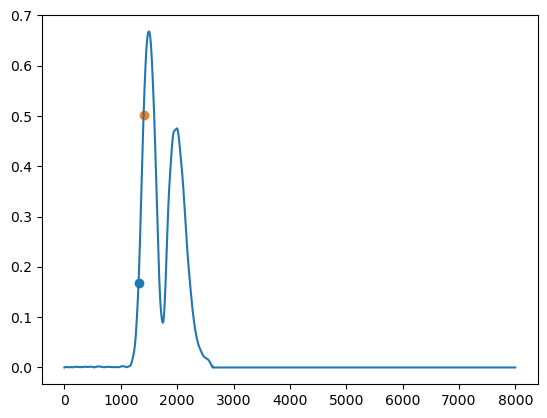

In [ ]:
plt.plot(reaction_velocity_data[0,0,4,:])
plt.scatter(max25_timepoints[0,0,4],max25[0,0,4])
plt.scatter(max75_timepoints[0,0,4],max75[0,0,4])

In [ ]:
player_reaction_time_force

array([[[1144.5, 1899.5, 2818.5, 2678. , 1176. , 2210. , 1779. , 3655.5,
         1210. , 1048. , 2706.5, 3560.5, 1646. , 3071. , 2752.5, 1100. ,
         3091.5, 2342. , 1497.5, 2856.5, 2110. , 1953.5, 3339.5, 1835. ,
         2489. , 2384.5, 2958.5, 2613.5, 1527. , 2381.5, 2161.5, 2433. ,
         1588. , 2062.5, 2163. , 1634.5, 1569.5, 2642. , 3115. , 2456. ,
         1961.5, 1668. , 2146. , 1528. , 2439.5, 1577.5, 1926. , 1320.5,
         1741.5, 1224. , 1517.5, 2128.5, 1737.5, 1195.5, 1773.5, 1770. ,
         1733.5, 1787. ,  935.5, 2456.5, 1153.5, 1077.5,  960.5, 1623. ,
         1223. , 1177. , 1614. , 1908.5, 1653.5, 1548. , 2039.5, 1110.5,
          985.5, 2567. , 2669. , 2634. , 1965.5, 2908. , 1030.5, 1598.5,
         1819. , 1134. , 1708.5, 1583.5, 1313.5,  988. , 1892. , 2542.5,
         2200. , 3054. , 1568. , 1786. , 1614. , 1228.5, 2294. , 1653.5,
         1605.5, 3633. , 1060.5, 5540. ],
        [1572.5, 1672.5, 1068. , 1884. , 2178.5, 1142.5, 2282. , 2808.5,
         

In [ ]:
data - max25_array

array([[[[-0.12970086, -0.12973407, -0.12976789, ..., -0.13041435,
          -0.13041435, -0.13041435],
         [-0.11166375, -0.11170968, -0.11175609, ..., -0.11428612,
          -0.11428612, -0.11428612],
         [-0.16090534, -0.16090881, -0.16091218, ..., -0.16140295,
          -0.16140295, -0.16140295],
         ...,
         [-0.13512677, -0.13518954, -0.13525236, ..., -0.14415847,
          -0.14415847, -0.14415847],
         [-0.18577521, -0.18573543, -0.18569772, ..., -0.18612714,
          -0.18612714, -0.18612714],
         [-0.13341904, -0.13350505, -0.13358673, ..., -0.14303914,
          -0.14303914, -0.14303914]],

        [[-0.1798231 , -0.17981788, -0.17981961, ..., -0.18258098,
          -0.18258098, -0.18258098],
         [-0.20720757, -0.20714313, -0.20707953, ..., -0.20937149,
          -0.20937149, -0.20937149],
         [-0.19831052, -0.19884445, -0.19936716, ..., -0.20348782,
          -0.20348782, -0.20348782],
         ...,
         [ 0.        ,  0.        

In [ ]:
np.argmin(data - max25_array,axis=3)

array([[[4284, 2760, 2573, 2915, 2627, 2390, 2672, 3235, 2536, 2306,
         2714, 3111, 2376, 2687, 2455, 2352, 2713, 2581, 2237, 2423,
         2466, 2290, 2787, 2408, 2544, 2424, 2539, 2439, 2317, 2387,
         2249, 2404, 2370, 3285, 2816, 2328, 2947, 2336, 2742, 2255,
         2280, 2350, 2308, 2229, 2390, 2377, 2725, 2601, 2460, 2570,
         2826, 2837, 2551, 2525, 2506, 2514, 2565, 2597, 2732, 3122,
         2537, 2369, 2343, 2385, 2499, 2476, 2427, 3288, 2490, 2965,
         2886, 2478, 2341, 2628, 2508, 2472, 2462, 2514, 2539, 3108,
         2568, 2613, 2456, 2427, 2816, 2414, 2600, 3259, 2922, 2612,
         2424, 2555, 2367, 2527, 2444, 2417, 2479, 3103, 2373, 6406],
        [2455, 2428, 2451, 2536, 2423, 2571, 2818, 2437, 2607, 2503,
         2567, 2678, 2334, 2464, 2473, 2459, 2436, 2523, 2481, 2432,
         2538, 2580, 2433, 2524, 2499, 2595, 2640, 2802, 2606, 2401,
         2636, 2585, 2654, 2567, 2592, 2485, 2482, 2622, 2746, 2533,
         2573, 2501, 2595, 2527, 

In [ ]:
np.argmin(data - max75_array,axis=3)

array([[[4284, 2760, 2573, 2915, 2627, 2390, 2672, 3235, 2536, 2306,
         2714, 3111, 2376, 2687, 2455, 2352, 2713, 2581, 2237, 2423,
         2466, 2290, 2787, 2408, 2544, 2424, 2539, 2439, 2317, 2387,
         2249, 2404, 2370, 3285, 2816, 2328, 2947, 2336, 2742, 2255,
         2280, 2350, 2308, 2229, 2390, 2377, 2725, 2601, 2460, 2570,
         2826, 2837, 2551, 2525, 2506, 2514, 2565, 2597, 2732, 3122,
         2537, 2369, 2343, 2385, 2499, 2476, 2427, 3288, 2490, 2965,
         2886, 2478, 2341, 2628, 2508, 2472, 2462, 2514, 2539, 3108,
         2568, 2613, 2456, 2427, 2816, 2414, 2600, 3259, 2922, 2612,
         2424, 2555, 2367, 2527, 2444, 2417, 2479, 3103, 2373, 6406],
        [2455, 2428, 2451, 2536, 2423, 2571, 2818, 2437, 2607, 2503,
         2567, 2678, 2334, 2464, 2473, 2459, 2436, 2523, 2481, 2432,
         2538, 2580, 2433, 2524, 2499, 2595, 2640, 2802, 2606, 2401,
         2636, 2585, 2654, 2567, 2592, 2485, 2482, 2622, 2746, 2533,
         2573, 2501, 2595, 2527, 

In [ ]:
player_yforce_reaction_time_vec = get_velocity_linear_reaction_time(reaction_velocity_data) - agent_reaction_decision_time


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
np.nanmax(reaction_velocity_data,axis=3).shape

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\2584596184.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(reaction_velocity_data,axis=3).shape


(2, 3, 100)

In [ ]:
np.nanmean(player_yforce_reaction_time[0,0,1])

-228.0759277343751

In [ ]:
np.nanmean(player_velocity_reaction_time[0,0,1])

369.924072265625

In [ ]:
player_reaction_time[0,0,:]

array([ 875.62176514,  423.42407227,  399.11334229,  756.69647217,
        521.59692383,  334.18280029,  588.12921143,  785.5534668 ,
        502.90905762,  397.60473633,  630.19250488, 1056.04290771,
        295.07672119,  757.90692139,  408.61328125,  375.046875  ,
        679.74060059,  632.20733643,  324.01391602,  393.8416748 ,
        422.38574219,  279.76660156,  840.84863281,  498.46972656,
        569.71203613,  467.4128418 ,  475.20123291,  420.56884766,
        298.96478271,  395.00256348,  313.50048828,  417.49487305,
        378.88989258, 1278.28564453,  785.34973145,  365.49816895,
        849.29418945,  374.06994629,  755.62939453,  315.82965088,
        290.70794678,  315.53411865,  302.01257324,  308.30108643,
        339.4899292 ,  372.72302246,  753.59472656,  578.58795166,
        334.20001221,  473.1395874 ,  548.37445068,  803.31890869,
        445.25250244,  483.99328613,  522.18157959,  428.89331055,
        499.05566406,  590.3480835 ,  306.19592285,  944.23211

In [ ]:
player_velocity_reaction_time[0,0,:]

array([ 807.12176514,  369.92407227,  361.61334229,  688.19647217,
        476.59692383,  293.68280029,  540.12921143,  738.5534668 ,
        471.40905762,  354.60473633,  591.19250488, 1023.04290771,
        256.57672119,  720.40692139,  370.11328125,  324.046875  ,
        639.24060059,  589.70733643,  282.01391602,  354.8416748 ,
        457.38574219,  248.26660156,  792.34863281,  465.96972656,
        536.21203613,  435.9128418 ,  435.70123291,  391.06884766,
        260.96478271,  361.00256348,  273.00048828,  378.99487305,
        342.88989258, 1237.78564453,  795.84973145,  329.99816895,
        817.29418945,  368.06994629,  712.62939453,  287.32965088,
        255.20794678,  291.03411865,  259.51257324,  282.30108643,
        295.4899292 ,  329.22302246,  715.09472656,  526.08795166,
        316.70001221,  427.1395874 ,  686.87445068,  773.31890869,
        406.25250244,  449.49328613,  468.18157959,  378.39331055,
        457.05566406,  543.8480835 ,  165.69592285,  873.73211

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\869143761.py:1: RuntimeWarning: All-NaN slice encountered
  plt.scatter(np.nanmax(reaction_velocity_data[0,1,:,:],axis=1),player_reaction_time_vel[0,1,:],c='blue')
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\869143761.py:2: RuntimeWarning: All-NaN slice encountered
  plt.scatter(np.nanmax(reaction_velocity_data[0,1,:,:],axis=1),player_velocity_reaction_time[0,1,:],c='orange')
C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\869143761.py:3: RuntimeWarning: All-NaN slice encountered
  plt.scatter(np.nanmax(reaction_yforce_data[0,1,:,:],axis=1),player_yforce_reaction_time[0,1,:],c='green')


(0.0, 1500.0)

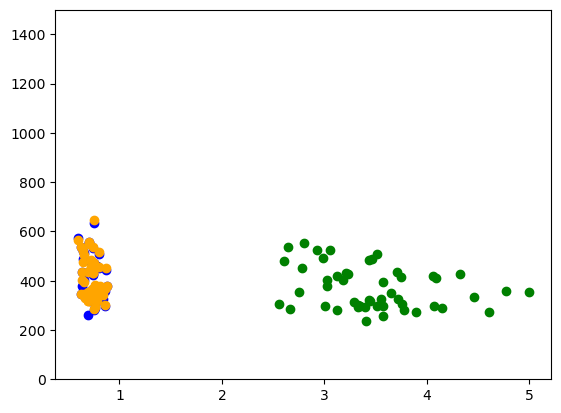

In [ ]:
plt.scatter(np.nanmax(reaction_velocity_data[0,1,:,:],axis=1),player_reaction_time_vel[0,1,:],c='blue')
plt.scatter(np.nanmax(reaction_velocity_data[0,1,:,:],axis=1),player_velocity_reaction_time[0,1,:],c='orange')
plt.scatter(np.nanmax(reaction_yforce_data[0,1,:,:],axis=1),player_yforce_reaction_time[0,1,:],c='green')
plt.ylim(0,1500)

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\3994567046.py:1: RuntimeWarning: All-NaN slice encountered
  plt.scatter(np.nanmax(reaction_velocity_data[0,0,:,:],axis=1),np.nanmax(reaction_yforce_data[0,1,:,:],axis=1))


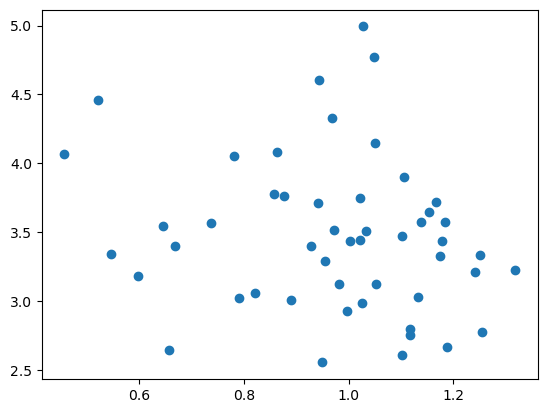

In [ ]:
plt.scatter(np.nanmax(reaction_velocity_data[0,0,:,:],axis=1),np.nanmax(reaction_yforce_data[0,1,:,:],axis=1))
# plt.ylim(0,1500)

In [ ]:
player_reaction_time_vel[0,0,:]

array([ 822.62176514,  384.42407227,  360.11334229,  696.69647217,
        461.59692383,  289.18280029,  538.12921143,  734.5534668 ,
        460.90905762,  345.60473633,  554.19250488, 1004.04290771,
        255.07672119,  694.90692139,  351.61328125,  314.046875  ,
        633.74060059,  574.20733643,  273.01391602,  342.8416748 ,
        397.38574219,  233.76660156,  787.84863281,  451.46972656,
        512.71203613,  420.4128418 ,  427.20123291,  381.56884766,
        241.96478271,  349.00256348,  258.50048828,  361.49487305,
        328.88989258, 1225.28564453,  681.34973145,  314.49816895,
        806.29418945,  356.06994629,  704.62939453,  276.82965088,
        249.70794678,  284.53411865,  259.01257324,  275.30108643,
        283.4899292 ,  320.72302246,  709.59472656,  524.58795166,
        311.20001221,  430.1395874 ,  689.37445068,  754.31890869,
        401.25250244,  452.99328613,  450.18157959,  370.89331055,
        363.05566406,  543.3480835 ,  270.19592285,  889.23211

In [ ]:
player_velocity_reaction_time[0,0,:] - player_reaction_time_vel[0,0,:]

array([-1.55000000e+01, -1.45000000e+01,  1.50000000e+00, -8.50000000e+00,
        1.50000000e+01,  4.50000000e+00,  2.00000000e+00,  4.00000000e+00,
        1.05000000e+01,  9.00000000e+00,  3.70000000e+01,  1.90000000e+01,
        1.50000000e+00,  2.55000000e+01,  1.85000000e+01,  1.00000000e+01,
        5.50000000e+00,  1.55000000e+01,  9.00000000e+00,  1.20000000e+01,
        6.00000000e+01,  1.45000000e+01,  4.50000000e+00,  1.45000000e+01,
        2.35000000e+01,  1.55000000e+01,  8.50000000e+00,  9.50000000e+00,
        1.90000000e+01,  1.20000000e+01,  1.45000000e+01,  1.75000000e+01,
        1.40000000e+01,  1.25000000e+01,  1.14500000e+02,  1.55000000e+01,
        1.10000000e+01,  1.20000000e+01,  8.00000000e+00,  1.05000000e+01,
        5.50000000e+00,  6.50000000e+00,  5.00000000e-01,  7.00000000e+00,
        1.20000000e+01,  8.50000000e+00,  5.50000000e+00,  1.50000000e+00,
        5.50000000e+00, -3.00000000e+00, -2.50000000e+00,  1.90000000e+01,
        5.00000000e+00, -

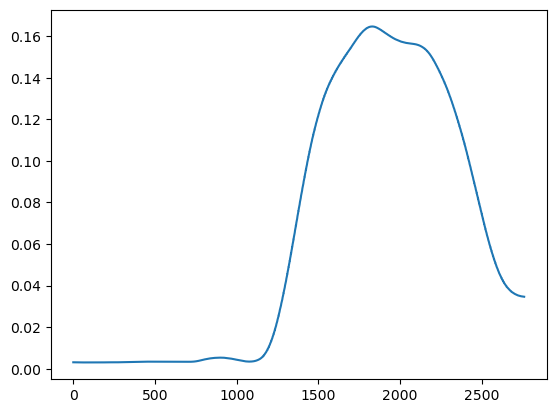

In [ ]:
plt.plot(reaction_dist_data[0,0,1,:])

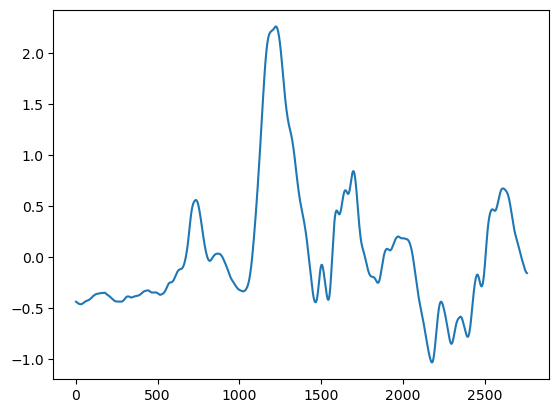

In [ ]:
plt.plot(reaction_yforce_data[0,0,1,:])

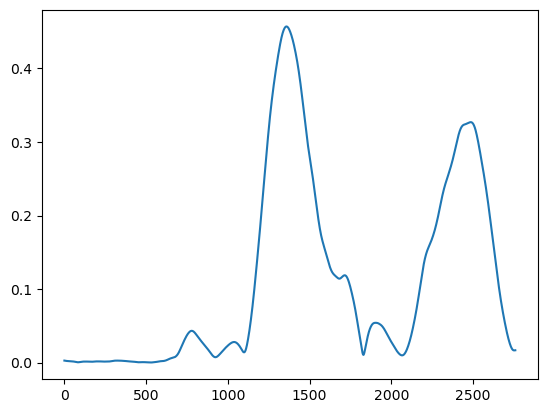

In [ ]:
plt.plot(reaction_velocity_data[0,0,1,:])

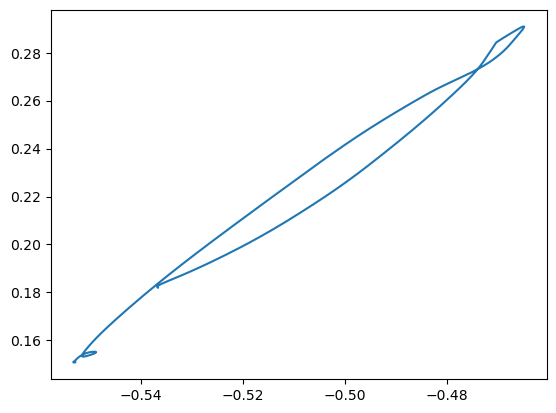

In [ ]:
plt.plot(reaction_pos_data[0,0,1,:5000,0],reaction_pos_data[0,0,1,:5000,1])


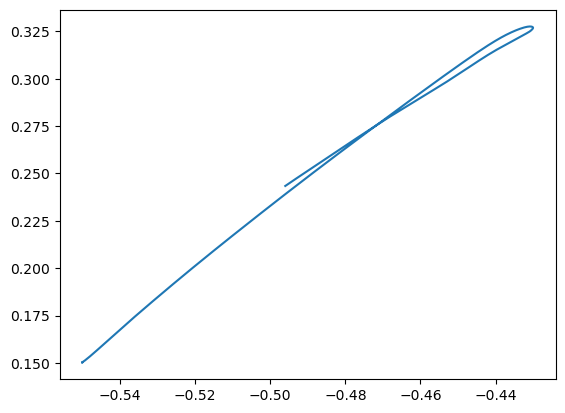

In [ ]:
plt.plot(reaction_pos_data[i,j,40,:,0],reaction_pos_data[i,j,40,:,1])


Split up reaction times (just testing, this is implemented in subject object)


In [ ]:
filename

'Sub10_Reaction\\Matchpennies_Agent_Exp2_Sub10_Reaction_C3_TP3_T50.csv'

In [ ]:
#* Split into react and gamble trials for first block
react_reaction_times = player_reaction_time[trial_type_array==1].reshape(num_subjects,2,50)   
gamble_reaction_times = player_reaction_time[trial_type_array==0].reshape(num_subjects,2,50) 

react_reaction_time_mixed = react_reaction_times[:,0,:]
react_reaction_time_only_react = react_reaction_times[:,1,:]
gamble_reaction_time_mixed = gamble_reaction_times[:,0,:]
gamble_reaction_time_only_gamble = gamble_reaction_times[:,1,:]

ALign force data


In [ ]:
# Align force data
reaction_yforce_data_aligned = np.zeros_like(reaction_yforce_data)
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if np.isnan(agent_reaction_decision_time[i,j,k]):
                break
            x = int(agent_reaction_decision_time[i,j,k])
            reaction_yforce_data_aligned[i,j,k,:] = np.roll(reaction_yforce_data[i,j,k,:],-x)
reaction_yforce_data_aligned[...,1000:] = np.nan

Split into react and gamble trials, mixed and only


In [ ]:
#* Split into react and gamble trials for first block
shutoff_mask = trial_type_array==0
go_mask = trial_type_array==1
force_react_mask      = np.repeat(go_mask[...,np.newaxis],5000,axis=3)
force_gamble_mask     = np.repeat(shutoff_mask[...,np.newaxis],5000,axis=3)

react_yforce_data = reaction_yforce_data_aligned[force_react_mask].reshape(num_subjects,2,50,5000)   
gamble_yforce_data = reaction_yforce_data_aligned[force_gamble_mask].reshape(num_subjects,2,50,5000)   

react_yforce_data_mixed = react_yforce_data[:,0,...]
react_yforce_data_only_react = react_yforce_data[:,1,...]

gamble_yforce_data_mixed = gamble_yforce_data[:,0,...]
gamble_yforce_data_only_gamble = gamble_yforce_data[:,1,...]

IndexError: boolean index did not match indexed array along dimension 3; dimension is 8000 but corresponding boolean dimension is 5000

Plot all the traces


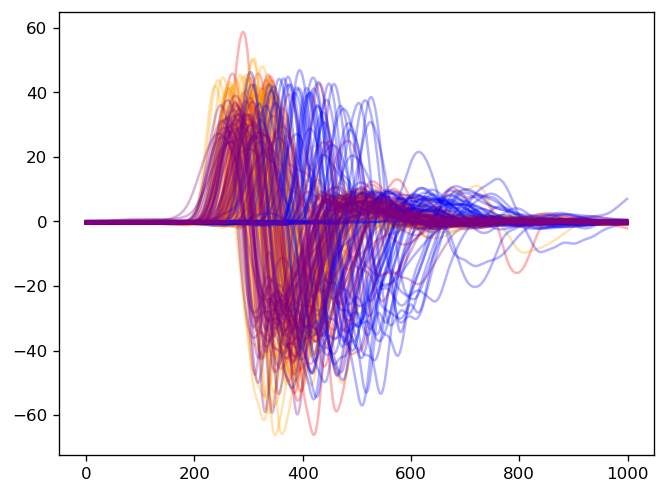

In [ ]:
fig,ax = plt.subplots(dpi=120)
# colors = iter(cm.rainbow(np.linspace(0, 1, 100)))
colors = ['red','orange','blue','purple']
data = [react_yforce_data_mixed,react_yforce_data_only_react,gamble_yforce_data_mixed,gamble_yforce_data_only_gamble]
for i,d in enumerate(data):
    for k in range(50):        
        ax.plot(d[4,k,:],c=colors[i],alpha = 0.3)
    # ax.set_xlim(0,3000)

Define mean function


In [ ]:
# def get_max_force_percentiles(data):
#     #* Get average across all trials for each subject
#     mean_force = np.nanmean(data,axis=1)

#     #* Find max peak in average signal and find 0.25 and 0.75 of the averaged force values
#     max_mean_force = np.nanmax(mean_force,axis=1)
#     index_max_mean_force = np.nanargmax(mean_force,axis=1)
#     max25 = 0.25*max_mean_force
#     max75 = 0.75*max_mean_force
#     max25_timepoint = np.zeros((num_subjects))
#     max75_timepoint = np.zeros_like(max25_timepoint)
#     for i in range(num_subjects):
#         a,_ = min(enumerate(mean_force[i,:index_max_mean_force[i]]), key=lambda x: abs(x[1]-max25[i])) # Enumerate mean force to get timepoint and value, only slice up to the max value, then find where it's closest to 25percent of max value
#         max25_timepoint[i] = a
#         b,_ = min(enumerate(mean_force[i,:index_max_mean_force[i]]), key=lambda x: abs(x[1]-max75[i]))
#         max75_timepoint[i] = b

#     return mean_force,max_mean_force,index_max_mean_force,max25,max75,max25_timepoint,max75_timepoint

class Data():
    def __init__(self,data):
        self.data = data
        self.num_subjects = 7
        self.get_max_force_percentiles()
    def get_max_force_percentiles(self):
        #* Get average across all trials for each subject, each block
        self.mean_force = np.nanmean(self.data,axis=1)

        #* Find max peak in average signal and find 0.25 and 0.75 of the averaged force values
        self.max_mean_force = np.nanmax(self.mean_force,axis=1)
        self.index_max_mean_force = np.nanargmax(self.mean_force,axis=1)
        self.max25 = 0.25*self.max_mean_force
        self.max75 = 0.75*self.max_mean_force
        self.max25_timepoint = np.zeros((num_subjects))
        self.max75_timepoint = np.zeros_like(self.max25_timepoint)
        for i in range(self.num_subjects):
            a,_ = min(enumerate(self.mean_force[i,:self.index_max_mean_force[i]]), key=lambda x: abs(x[1]-self.max25[i])) # Enumerate mean force to get timepoint and value, only slice up to the max value, then find where it's closest to 25percent of max value
            self.max25_timepoint[i] = a
            b,_ = min(enumerate(self.mean_force[i,:self.index_max_mean_force[i]]), key=lambda x: abs(x[1]-self.max75[i]))
            self.max75_timepoint[i] = b
        self.x1vals = self.max25_timepoint
        self.x2vals = self.max75_timepoint
        self.y1vals = self.max25
        self.y2vals = self.max75
        self.slopes = (self.y2vals - self.y1vals)/(self.x2vals - self.x1vals)
        self.intercepts = self.y2vals - self.slopes*self.x2vals
        self.time_at_zero = -self.intercepts/self.slopes
        self.player_reaction_time_force = self.time_at_zero


    

In [ ]:
def plot(objects,label):
    colors = cm.rainbow(np.linspace(0, 1, 4))
    
    
    for i in range(num_subjects):
        fig,ax = plt.subplots(dpi=170)
        for j,o in enumerate(objects):
            x1 = o.mean_force[i,:]
            x1line = o.slopes[i]*np.arange(0,1000) + o.intercepts[i]

            ax.plot(np.arange(0,1000),x1[:1000],c =colors[j],label=label[j])
            ax.scatter(o.max25_timepoint[i],o.max25[i],c='grey')
            ax.scatter(o.max75_timepoint[i],o.max75[i],c='grey')
            ax.plot(x1line,c=colors[j],ls='--')

            ax.scatter(o.index_max_mean_force[i],o.max_mean_force[i],marker='x')

            ax.set_ylim(0,max(o.max_mean_force+1))
            # ax.set_xlim(0,800)
            ax.legend()
        plt.show()

In [ ]:
react_mixed = Data(react_yforce_data_mixed)
react_only_react = Data(react_yforce_data_only_react)
gamble_mixed = Data(gamble_yforce_data_mixed)
gamble_only_gamble = Data(gamble_yforce_data_only_gamble)
# mean_react_mixed, max_mean_react_mixed, index_max_mean_react_mixed, max25_react_mixed, max75_react_mixed, max25_timepoint_react_mixed, max75_timepoint_react_mixed = get_max_force_percentiles(react_yforce_data_mixed)
# mean_only_react, max_mean_only_react, index_max_mean_only_react, max25_only_react, max75_only_react, max25_timepoint_only_react, max75_timepoint_only_react = get_max_force_percentiles(react_yforce_data_only_react)
# mean_only_gamble, max_mean_only_gamble, index_max_mean_only_gamble, max25_only_gamble, max75_only_gamble, max25_timepoint_only_gamble, max75_timepoint_only_gamble = get_max_force_percentiles(gamble_yforce_data_only_gamble)
# mean_gamble_mixed, max_mean_gamble_mixed, index_max_mean_gamble_mixed, max25_gamble_mixed, max75_gamble_mixed, max25_timepoint_gamble_mixed, max75_timepoint_gamble_mixed = get_max_force_percentiles(gamble_yforce_data_mixed)
o = [react_mixed,react_only_react,gamble_mixed,gamble_only_gamble]

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_40380\1822391004.py:27: RuntimeWarning: Mean of empty slice
  self.mean_force = np.nanmean(self.data,axis=1)


Compare Mean Force Profile, Leave Target, and Mean of Each Force Profile


In [ ]:
print(f'Mean Force Profile Diff: {react_mixed.player_reaction_time_force - gamble_mixed.player_reaction_time_force}')


Mean Force Profile Diff: [  -4.5  -34.   -51.  -146.   -25.5  -83.5   10. ]


In [ ]:
# plot(o,label=['React_Mixed','React (only)','Gamble Mixed','Gamble Only'])

# Pickle Reaction Stuff


In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(reaction_dist_data[i,:,:], open(data_path + f'{subname}_reaction_dist_data.pkl', 'wb'))
    dill.dump(reaction_yforce_data[i,:,:], open(data_path + f'{subname}_reaction_yforce_data.pkl', 'wb'))
    dill.dump(player_reaction_time[i,:,:], open(data_path + f'{subname}_player_reaction_time.pkl', 'wb'))
    dill.dump(player_yforce_reaction_time[i,:,:], open(data_path + f'{subname}_player_yforce_reaction_time.pkl', 'wb'))
    dill.dump(player_reaction_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_movement_time.pkl', 'wb'))
    dill.dump(player_yforce_reaction_movement_time[i,:,:],open(data_path + f'{subname}_player_yforce_reaction_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_plus_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_plus_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_decision_array[i,:,:], open(data_path + f'{subname}_player_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_array[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_time[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_time.pkl', 'wb'))
    dill.dump(trial_type_array[i,:,:], open(data_path + f'{subname}_reaction_trial_type_array.pkl', 'wb'))
    # dill.dump(agent_decision_time[i,:], open(data_path + f'{subname}_agent_decision_time.pkl', 'wb'))


Sub1
Subjects_Analyzed\Sub1\
Sub2
Subjects_Analyzed\Sub2\
Sub4
Subjects_Analyzed\Sub4\
Sub5
Subjects_Analyzed\Sub5\
Sub6
Subjects_Analyzed\Sub6\
Sub7
Subjects_Analyzed\Sub7\
Sub8
Subjects_Analyzed\Sub8\


# Parse Timing Data


In [ ]:
coincidence_trial_time = 2500
coincidence_trials = 50
coincidence_trial_start = np.zeros((num_subjects, coincidence_trials))*np.nan
coincidence_reach_time = np.zeros((num_subjects, coincidence_trials))*np.nan

interval_trial_time = 2500
interval_trials = 50
interval_trial_start = np.zeros((num_subjects, interval_trials))*np.nan
interval_reach_time =  np.zeros((num_subjects, interval_trials))*np.nan

control_trials = interval_trials + coincidence_trials
###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_timing[i]
    print(i, sub_name)
    file = f'{sub_name}\\{sub_name}Trial_Table.csv'
    control_trial_table = pd.read_csv(file)
    block_number = 1
    tp_num = 1
    for x in ((range(control_trials))):
        block_number = control_trial_table.iloc[x]['Block_Row']
        tp_num = control_trial_table.iloc[x]['TP_Row']
        block_trial_num = control_trial_table.iloc[x]['Block_Step']
        filename = f'{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv'
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        data = pd.read_csv(filename, low_memory=False)
        # if 'Agent_Initial_Time' in data.columns:
        #     data = data.rename(columns = {'Agent_Inital_Time':'Agent_Decision_Time'}, inplace=True)
        # f = data['Agent_Decision_Time']
        start_time = int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        # Get Interval Timing Data
        if tp_num == 1:
            end_time = start_time + interval_trial_time
            interval_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                interval_reach_time[i,k] = q[0]
        # Get Coincidence Timing Data
        if tp_num == 2:
            end_time = start_time + coincidence_trial_time
            coincidence_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                coincidence_reach_time[i,k] = q[0] 
                
            # #plot path for Reactions
            if False:
                for i in range(1):
                    player_reaction_time[0,0] = 500
                    plot_end_time = int(start_time + player_reaction_time[i,k])
                    # plot_end_time = int(start_time + 500)
                    lhx_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                    lhy_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                    plt.figure(dpi=300)
                    circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                    circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                    startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                    fig, ax = plt.subplots()
                    ax.add_patch(circleR)
                    ax.add_patch(circleL)
                    ax.add_patch(startCirc)
                    plt.plot(lhx_new,lhy_new) 
                    # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                    print(player_reaction_time[i,k])
                    # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                    plt.show()

0 Sub1_Timing
1 Sub2_Timing
2 Sub4_Timing
3 Sub5_Timing
4 Sub6_Timing
5 Sub7_Timing
6 Sub8_Timing


# Pickle Timing Data


In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(interval_trial_start[i,:], open(data_path + f'{subname}_interval_trial_start.pkl', 'wb'))
    dill.dump(interval_reach_time[i,:], open(data_path + f'{subname}_interval_reach_time.pkl', 'wb'))
    dill.dump(coincidence_trial_start[i,:], open(data_path + f'{subname}_coincidence_trial_start.pkl', 'wb'))
    dill.dump(coincidence_reach_time[i,:], open(data_path + f'{subname}_coincidence_reach_time.pkl', 'wb'))
    

Sub1
Subjects_Analyzed\Sub1\
Sub2
Subjects_Analyzed\Sub2\
Sub4
Subjects_Analyzed\Sub4\
Sub5
Subjects_Analyzed\Sub5\
Sub6
Subjects_Analyzed\Sub6\
Sub7
Subjects_Analyzed\Sub7\
Sub8
Subjects_Analyzed\Sub8\


# Parse Task Data


In [ ]:
#%% Get task time task_df
# Get trials, blocks, trial_time from trial_table
path1 = PATH+'\\'+'Sub1_Task'
task_df = pd.read_csv(path1+f'\\Sub1_TaskTrial_Table.csv')
task_df = task_df.loc[task_df['Condition type']==3] # Only get the task condition 
num_trials = int(task_df.iloc[-1]['Block_Step']) # number of trials in each block
num_blocks = int(task_df.iloc[-1]['Block_Row'])
tot_trials = int(num_trials*num_blocks)
trial_time = int(task_df.iloc[0]['Condition time'])
task_df_columns = len(fields_pull)
# Need to be kept outside subject for-loop
task_trial_end = np.zeros([num_subjects, num_blocks, num_trials, 2])*np.nan
task_trial_start = np.zeros((num_subjects, num_blocks, num_trials))*np.nan
filename_storage = np.empty((num_subjects, num_blocks, num_trials), dtype=object)

task_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, task_df_columns))*np.nan
task_yforce_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500))*np.nan
task_dist_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500))*np.nan
win_check_R = np.zeros((num_subjects, num_blocks))
win_check_L = np.zeros((num_subjects, num_blocks))
num_miss_check_R = np.zeros((num_subjects, num_blocks))
num_miss_check_L = np.zeros((num_subjects, num_blocks))
#########
player_task_decision_array = np.empty((num_subjects, num_blocks, num_trials))
player_task_reach_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_decision_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_yforce_task_decision_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_movement_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_yforce_task_movement_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
agent_task_decision_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_reach_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_decision_array = np.zeros((num_subjects, num_blocks, num_trials))

###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_task[i]
    print(i, sub_name)
    path1 = PATH+'\\'+sub_name
    file = path1+f'\\{sub_name}Trial_Table.csv'
    trial_table = pd.read_csv(file)
    # Splt trial table into task and washout based on condition type
    task_trial_table = trial_table[trial_table['Condition type']==3]
    block_number = 1
    tp_num = 1
    for x in tqdm((range(tot_trials))):
        block_number = task_trial_table.iloc[x]['Block_Row']
        tp_num = task_trial_table.iloc[x]['TP_Row']
        block_trial_num = task_trial_table.iloc[x]['Block_Step']
        j = tp_num - task_trial_table['TP_Row'].min()  # Block number
        k = block_trial_num - 1 # Trial number in that block
        
        filename = PATH+f"\\{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        task_df = pd.read_csv(filename, low_memory=False)
        start_time = int(task_df[task_df['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        end_time = start_time + trial_time + 500 # Add 500 to see when they got there when trial ended
        data_task_df = task_df.drop(columns ='Event_Codes') # Drop event codes cuz it's not number column and can't be an array 
        task_data[i,j,k,:,:] = np.array(data_task_df.iloc[start_time:end_time])

        task_trial_start[i,j,k] = start_time
        lhx = np.array(task_df.iloc[start_time:end_time]['Left_HandX'])
        lhy = np.array(task_df.iloc[start_time:end_time]['Left_HandY'])
        pos = np.sqrt((lhx-startx)**2 + (lhy-starty)**2)
        lhx_force = task_df.iloc[start_time:end_time]['Left_FS_ForceX'].to_numpy()
        lhy_force = task_df.iloc[start_time:end_time]['Left_FS_ForceY'].to_numpy()
        fx_nan_mask = ~np.isnan(lhx_force)
        fy_nan_mask = ~np.isnan(lhy_force)
        lhx_force_filt = np.zeros(trial_time+500)*np.nan
        lhy_force_filt = np.zeros(trial_time+500)*np.nan
        lhx_force_filt[:np.count_nonzero(fx_nan_mask)] = ff.Filter_KIN(lhx_force[fx_nan_mask])
        lhy_force_filt[:np.count_nonzero(fy_nan_mask)] = ff.Filter_KIN(lhy_force[fy_nan_mask])
        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-startx)**2 + (lhy-starty)**2) > adjusted_start_radius) # Multiplied by 2 so people don't accidentally drift outside start
        
        task_dist_data[i,j,k,:len(pos)] = pos
        task_yforce_data[i,j,k,:len(lhy_force_filt)] = lhy_force_filt
        player_yforce_task_decision_time[i,j,k] = get_force_reaction_time_single_trial(lhy_force_filt)
        # print(player_yforce_task_decision_time[i,j,k])
        #print(vel_check)
        agent_task_decision_time[i,j,k] = task_df.iloc[start_time+1]['Agent_Decision_Time'] 
        agent_task_reach_time[i,j,k] = agent_task_decision_time[i,j,k] + 150  
        agent_task_decision_array[i,j,k] = task_df.iloc[start_time+1]['Agent_Target_Selection']
        if np.size(s)>0: 
            vel_check = task_df.iloc[s[0]]['Left_HandYVel']
            player_task_decision_time[i,j,k] = s[0]
            
        if np.size(q)>0: #if LH enters right target
            player_task_decision_array[i,j,k] = 1
            player_task_movement_time[i,j,k] = q[0] - s[0]
            player_yforce_task_movement_time[i,j,k] = q[0] - player_yforce_task_decision_time[i,j,k]
            player_task_reach_time[i,j,k] = q[0]
        elif np.size(r)>0: #if LH enters left target
            player_task_decision_array[i,j,k] = -1   
            player_task_movement_time[i,j,k] = r[0] - s[0]
            player_yforce_task_movement_time[i,j,k] = r[0] - player_yforce_task_decision_time[i,j,k]
            player_task_reach_time[i,j,k] = r[0]
        if player_task_reach_time[i,j,k] > 1500 or np.isnan(player_task_reach_time[i,j,k]):
            player_task_decision_array[i,j,k] = 0
        if agent_task_reach_time[i,j,k]>1500:
            agent_task_decision_array[i,j,k] = 0    
        #plot path for tasks
        if False:
            for i in range(1):
                plot_end_time = int(start_time + player_task_reach_time[i,j,k])
                lhx_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                lhy_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                plt.figure(dpi=300)
                circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                fig, ax = plt.subplots()
                ax.add_patch(circleR)
                ax.add_patch(circleL)
                ax.add_patch(startCirc)
                plt.plot(lhx_new,lhy_new) 
                plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])

                plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                plt.show()
    print(player_task_decision_time[i,0,:])
           

0 Sub1_Task


100%|██████████| 320/320 [00:16<00:00, 19.90it/s]


[1046. 1352. 1568. 1521. 1401. 1440. 1480. 1468. 1129. 1359. 1322. 1457.
 1306. 1384. 1371. 1453. 1378. 1404. 1434. 1328. 1440. 1292. 1461. 1371.
 1334. 1373. 1388. 1435. 1409. 1374. 1343. 1255. 1439. 1309. 1310. 1398.
 1414. 1342. 1366. 1403. 1383. 1385. 1360. 1391. 1422. 1397. 1325. 1331.
 1380. 1377. 1397. 1344. 1352. 1476. 1345. 1307. 1382. 1367. 1415. 1348.
 1448. 1417. 1381. 1383. 1351. 1389. 1354. 1390. 1373. 1350. 1379. 1331.
 1430. 1362. 1342. 1324. 1372. 1233. 1333. 1405.]
1 Sub2_Task


100%|██████████| 320/320 [00:07<00:00, 44.27it/s]


[1416.  910. 1114.  843. 1453. 1413. 1388. 1514. 1337. 1160. 1414. 1492.
 1336. 1391. 1206. 1303. 1434. 1511.  926. 1325. 1335. 1371. 1401. 1467.
 1125. 1436. 1310. 1325. 1431. 1136. 1517. 1339. 1516. 1305. 1328. 1306.
 1086. 1043. 1080. 1375. 1367. 1405. 1385. 1318. 1423. 1112.   nan 1380.
 1233.   nan 1396. 1200. 1434. 1259. 1284. 1434. 1244. 1312. 1147. 1354.
  965. 1218. 1414. 1166.   nan 1395. 1364. 1222. 1196. 1357. 1160. 1341.
 1002. 1417. 1303. 1402. 1213. 1289. 1359. 1309.]
2 Sub4_Task


100%|██████████| 320/320 [00:08<00:00, 37.99it/s]


[1389. 1361. 1265. 1351. 1305. 1375. 1333. 1255. 1350. 1278. 1334. 1387.
 1398. 1338. 1331. 1348. 1400. 1378. 1352. 1448. 1326. 1130. 1385. 1235.
 1388. 1374. 1129. 1329. 1193. 1381. 1422. 1330. 1381. 1248. 1257. 1290.
 1335. 1207. 1293. 1371. 1344. 1354. 1373. 1341. 1371. 1279. 1412. 1430.
 1437. 1243. 1303. 1296. 1328. 1391. 1381. 1331. 1406. 1312. 1355. 1410.
 1416. 1365. 1414. 1372. 1394. 1410. 1363. 1381. 1444. 1500. 1361. 1372.
 1362. 1247. 1297. 1412. 1415. 1327. 1427. 1367.]
3 Sub5_Task


100%|██████████| 320/320 [00:07<00:00, 45.38it/s]


[1317. 1519. 1297. 1014.  700. 1476. 1193. 1427. 1335. 1020. 1194. 1187.
 1062. 1409.  915. 1351. 1437. 1382. 1306. 1205. 1190. 1395. 1340. 1455.
 1416. 1338.  931.  719. 1049. 1344. 1091.  729. 1154. 1131. 1182. 1362.
 1282. 1429. 1092. 1304.  988. 1359. 1212.  838.  938.  960.  846.  871.
  809. 1384. 1321. 1376. 1236. 1394. 1110. 1164. 1250. 1198. 1125. 1094.
 1027. 1185. 1149. 1166. 1236. 1292. 1103. 1234. 1269. 1283. 1393. 1007.
 1080.  859. 1044. 1160. 1038.  963. 1110. 1155.]
4 Sub6_Task


100%|██████████| 320/320 [00:07<00:00, 41.24it/s]


[1329. 1328. 1539. 1495. 1350. 1326. 1375. 1319. 1375. 1348. 1287. 1290.
 1418. 1377. 1356. 1368. 1349. 1392. 1381. 1300. 1412. 1312. 1473. 1394.
 1334. 1350. 1373. 1359. 1355. 1327. 1466. 1346. 1286. 1334. 1351. 1439.
 1354. 1393. 1282. 1470. 1376. 1359. 1360. 1416. 1348. 1275. 1355. 1319.
 1333. 1257. 1355. 1416. 1405. 1430. 1486. 1321. 1301. 1353. 1319. 1399.
 1344. 1413. 1333. 1354. 1372. 1374. 1374. 1380. 1423. 1342. 1334. 1302.
 1406. 1385. 1292. 1382. 1366. 1355. 1353. 1459.]
5 Sub7_Task


100%|██████████| 320/320 [00:07<00:00, 45.38it/s]


[1418. 1363. 1346. 1355. 1384. 1327. 1415. 1351. 1305. 1346. 1409. 1328.
 1363. 1363. 1445. 1348. 1258. 1305. 1297. 1205. 1406. 1389. 1351. 1364.
 1346. 1344. 1370. 1400. 1365. 1329. 1279. 1353. 1404. 1222. 1360. 1417.
 1416. 1458. 1371. 1319. 1187. 1334. 1126. 1401. 1355. 1274. 1406. 1386.
 1443. 1348. 1360. 1327. 1386. 1268. 1391. 1176. 1353. 1042. 1356. 1412.
 1389. 1383. 1392. 1397. 1309. 1280. 1315. 1425. 1399. 1383. 1274. 1231.
 1315. 1468. 1279. 1332. 1328. 1259. 1285. 1359.]
6 Sub8_Task


100%|██████████| 320/320 [00:12<00:00, 25.29it/s]

[ 936. 1297. 1132. 1207. 1157. 1086. 1396. 1215. 1224. 1416. 1377. 1370.
 1301. 1407. 1350. 1446. 1041. 1111. 1086. 1168. 1151. 1098. 1353. 1213.
 1308. 1342. 1391. 1444. 1280. 1367. 1379. 1416. 1287. 1341. 1125. 1392.
 1430. 1140. 1341. 1351. 1272. 1317. 1224. 1035. 1412. 1265. 1363. 1279.
 1331. 1163. 1489. 1324. 1459. 1392. 1349. 1428. 1368. 1354. 1410. 1394.
 1437. 1379. 1403. 1376. 1429. 1503. 1451. 1125. 1409. 1425. 1308. 1202.
 1383. 1235. 1285. 1336. 1288. 1212. 1301. 1367.]


# Pickle Task Data


In [ ]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    dill.dump(task_yforce_data[i,:,:,:], open(data_path + f'{subname}_task_yforce_data.pkl', 'wb'))
    dill.dump(task_dist_data[i,:,:,:], open(data_path + f'{subname}_task_dist_data.pkl', 'wb'))
    dill.dump(player_task_decision_time[i,:,:], open(data_path + f'{subname}_player_task_decision_time.pkl', 'wb'))
    dill.dump(player_yforce_task_decision_time[i,:,:], open(data_path + f'{subname}_player_yforce_task_decision_time.pkl', 'wb'))
    dill.dump(player_task_decision_array[i,:,:], open(data_path + f'{subname}_player_task_decision_array.pkl', 'wb'))
    dill.dump(player_task_movement_time[i,:,:], open(data_path + f'{subname}_player_task_movement_time.pkl', 'wb'))
    dill.dump(player_yforce_task_movement_time[i,:,:], open(data_path + f'{subname}_player_yforce_task_movement_time.pkl', 'wb'))
    dill.dump(player_task_reach_time[i,:,:], open(data_path + f'{subname}_player_task_reach_time.pkl', 'wb'))
    dill.dump(agent_task_decision_time[i,:,:], open(data_path + f'{subname}_agent_task_decision_time.pkl', 'wb'))
    dill.dump(agent_task_decision_array[i,:,:], open(data_path + f'{subname}_agent_task_decision_array.pkl', 'wb'))
    dill.dump(agent_task_reach_time[i,:,:], open(data_path + f'{subname}_agent_task_reach_time.pkl', 'wb'))

Sub1
Sub2
Sub4
Sub5
Sub6
Sub7
Sub8


In [ ]:
def foo():
    #%% Get reaction time data
    block_table = pd.read_csv(f'Sub1_Reaction\\Sub1_ReactionBlock_Table.csv')
    num_trials = block_table['List_Reps'].loc[0]
    num_blocks = sum(~block_table['TP_LIST'].isna())
    trial_time = 5000
    tot_trials = int(sum(block_table['List_Reps']))

    filenames = np.empty((num_subjects, num_blocks,num_trials),dtype = object)
    trial_start = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    agent_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    agent_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan

    player_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan
    player_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_yforce_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_yforce_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_yforce_reaction_movement_time = np.zeros_like(player_yforce_reaction_time)
    player_reaction_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_reaction_plus_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_reaction_reach_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
    player_reaction_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

    trial_type_array = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

    reaction_pos_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time,2))*np.nan
    reaction_velocity_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
    reaction_dist_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
    reaction_force_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan
    reaction_yforce_data = np.zeros((num_subjects, num_blocks,num_trials, trial_time))*np.nan


    ###-------------------------------------------------------------------------------------------------------
    for i in range(1):
        subname = analysis_pull_list_reaction[i]
        print(i, subname)
        trial_table = pd.read_csv(subname+f'\\{subname}Trial_Table.csv')
        for x in range(tot_trials):
            block_trial_num = trial_table.iloc[x]['Block_Step']
            block_number = trial_table.iloc[x]['Block_Row']
            tp_num = trial_table.iloc[x]['TP_Row']
            j = tp_num - 1 # Block number
            k = block_trial_num - 1 # Trial number in that block
            
            filename = f"{subname}\\{task_name}_{subname}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
            filenames[i,j,k] = filename # Store the file name
            data = pd.read_csv(filename,low_memory=False)  # Read in data
            
            #* Find the trial start time with event codes
            event_code_col = data['Event_Codes']
            if 'E_GO_TRIAL' in event_code_col.unique():
                start_time = int(data[data['Event_Codes']=='E_GO_TRIAL'].index[-1]) #! Indexed at -1 bc if they need to redo the trial, we should use the last E_GO_TRIAL, not the first 
                trial_type_array[i,j,k] = 1 
            elif 'E_SHUTOFF_TRIAL' in event_code_col.unique():
                start_time = int(data[data['Event_Codes']=='E_SHUTOFF_TRIAL'].index[-1])
                trial_type_array[i,j,k] = 0
            else:
                raise Exception('ERROR, event code not found')
                
            #* Get Reaction Time Data
            end_time = start_time + trial_time      # Find how long the trial is, constant in this case to give people time to make it
            trial_start[i,j,k] = start_time         # Store the start times, NOT THE AGENT DECISION TIMES
            agent_reaction_decision_time[i,j,k] = data.iloc[start_time]['Agent_Decision_Time'] # Store the agent go time
            cutoff_data = data.iloc[start_time:end_time] # Constrain data to the time that the trial starts, to the time that it ends
                
            reaction_pos_data[i,j,k,:len(cutoff_data),:] = np.array(cutoff_data.drop(['Event_Codes'],axis=1)[['Left_HandX','Left_HandY']]) # Store left and right, slicing 3rd axis so if the trial ends early, then we just have nans at the end
            lhx = cutoff_data['Left_HandX'].to_numpy() # Left hand x position
            lhy = cutoff_data['Left_HandY'].to_numpy() # Left hand y position 
            lhx_vel = cutoff_data['Left_HandXVel'].to_numpy() # Left hand x velocity
            lhy_vel = cutoff_data['Left_HandYVel'].to_numpy() # Left hand y velocity
            lhx_force = cutoff_data['Left_FS_ForceX'].to_numpy()
            lhy_force = cutoff_data['Left_FS_ForceY'].to_numpy()
            # Filter force
            fx_nan_mask = ~np.isnan(lhx_force)
            fy_nan_mask = ~np.isnan(lhy_force)
            lhx_force_filt = np.zeros(trial_time)*np.nan
            lhy_force_filt = np.zeros(trial_time)*np.nan
            lhx_force_filt[:np.count_nonzero(fx_nan_mask)] = ff.Filter_KIN(lhx_force[fx_nan_mask])
            lhy_force_filt[:np.count_nonzero(fy_nan_mask)] = ff.Filter_KIN(lhy_force[fy_nan_mask])
            
            #* Get force, speed, dist and store them in arrays
            force = np.sqrt(lhx_force_filt**2 + lhy_force_filt**2)
            reaction_force_data[i,j,k,:] = force
            reaction_yforce_data[i,j,k,:] = lhy_force_filt
            speed = np.sqrt((lhx_vel)**2 + (lhy_vel)**2) # Calculate velocity
            reaction_velocity_data[i,j,k,:len(speed)] = speed # Store velocity 
            dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2) # Calculate dist
            reaction_dist_data[i,j,k,:len(dist)] = dist # Store dist

            player_yforce_reaction_time[i,j,k] = get_force_reaction_time_single_trial(lhy_force_filt) - agent_reaction_decision_time[i,j,k]
            player_yforce_reaction_decision_time[i,j,k] = get_force_reaction_time_single_trial(lhy_force_filt) 

            q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius) # Find when people enter the right target
            r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) # Find when people enter the left target
            s = np.argwhere(dist > adjusted_start_radius)  # Find when people leave the start
            t = np.argwhere(np.sqrt((lhx_vel)**2 + (lhy_vel)**2) > 0.05) # Find when people's velocity is greater than 0.05 cm/s
            
            if np.size(t)>0:
                player_reaction_time_vel[i,j,k] = t[0] - agent_reaction_decision_time[i,j,k]
            else:
                raise Exception('no velocity threshold crossed')
            if np.size(s)>0: 
                player_reaction_decision_time[i,j,k] = s[0]
                player_reaction_time[i,j,k] = s[0]  - agent_reaction_decision_time[i,j,k]
                
                #TODO Check lower threshold of speed up to the time that they leave the target to get the true decision time 
                
            else:
                raise Exception('no position threshold crossed')
            if np.size(q)>0: #if LH enters right target
                player_reaction_decision_array[i,j,k] = 1
                player_reaction_movement_time[i,j,k] = q[0] - s[0]
                player_yforce_reaction_movement_time[i,j,k] = q[0] - player_yforce_reaction_decision_time[i,j,k]
                player_reaction_plus_movement_time[i,j,k] = q[0] - agent_reaction_decision_time[i,j,k]
                
            elif np.size(r)>0: #if LH enters left target
                player_reaction_decision_array[i,j,k] = -1   
                player_reaction_movement_time[i,j,k] = r[0] - s[0]
                player_reaction_plus_movement_time[i,j,k] = r[0] - agent_reaction_decision_time[i,j,k]          
                player_yforce_reaction_movement_time[i,j,k] = r[0] - player_yforce_reaction_decision_time[i,j,k]

            # #plot path for Reactions
            if False:
                # for i in range(1):
                # plot_end_time = int(agent_reaction_decision_time[i,j,k] + player_reaction_time[i,j,k])
                # plot_end_time = int(start_time + 500)
                lhx_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandX'])
                lhy_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandY'])
                # plt.figure(dpi=300)
                # circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                # circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                # startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                # fig, ax = plt.subplots()
                # ax.add_patch(circleR)
                # ax.add_patch(circleL)
                # ax.add_patch(startCirc)
                # plt.plot(lhx,lhy) 
                # plt.show()
                # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                # print(player_reaction_time[i,j,k])
                # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                fig,ax = plt.subplots()
                dist = np.sqrt((lhx-startx)**2 + (lhy-starty)**2)
                plt.plot(dist)
                plt.scatter(s[0],dist[int(s[0])])
                plt.plot(speed)
                
                plt.scatter(t[0],speed[int(t[0])])
                plt.show()